# Evaluating predictions using patches created with a differing framework
- e.g. Does patch created with TF fool a PT estimator and vice versa

## Tensorflow estimator, Pytorch Patch

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch, AdversarialPatchTensorFlowV2

import os
import glob
import gzip
import pickle


########## Utility methods ###########

'''
Convert BGR to RGB
'''
def bgr_to_rgb(x):
    return x[:, :, ::-1]

'''
Predict top 5 classes for image
'''
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

#### Hyperparameters

In [2]:
target_name = 'goldfish, Carassius auratus'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

#### Model definition

In [3]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-10 16:13:31.189189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 16:13:31.189313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### ImageNet images

Load images, convert RGB to BGR. Further preprocessing passed to TensorFlowV2Classifier: zero-center each color channel with respect to ImageNet dataset [without scaling](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input#:~:text=The%20images%20are%20converted%20from%20RGB%20to%20BGR%2C%20then%20each%20color%20channel%20is%20zero%2Dcentered%20with%20respect%20to%20the%20ImageNet%20dataset%2C%20without%20scaling).

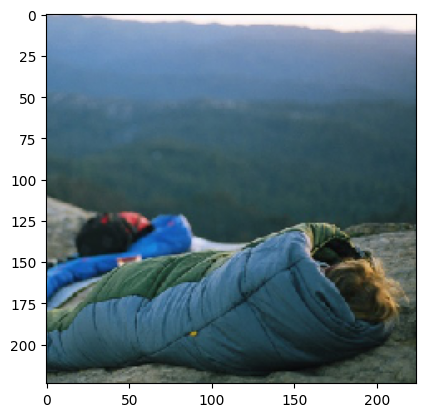

Predictions:
sleeping_bag  0.98
parachute     0.01
binoculars    0.00
balloon       0.00
mountain_tent 0.00


In [4]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

predict_model(tfc, images[0])

#### Load the Pytorch patch

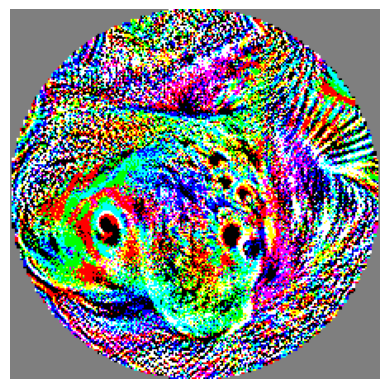

In [5]:
pt_patch = np.load('./pt_patch.npy')*255
#tf_patch = bgr_to_rgb(tf_patch)
pt_patch = pt_patch.transpose(1, 2, 0)
#pt_patch = np.flip(pt_patch,axis=1).copy()
pt_patch = pt_patch[...,::-1].copy()

plt.axis("off")
plt.imshow((bgr_to_rgb(pt_patch)).astype(np.uint))
plt.show()

### Make prediction

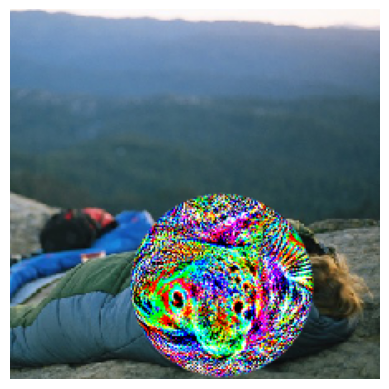

Predictions:
knot         0.09
Airedale     0.08
balloon      0.05
sleeping_bag 0.05
peacock      0.05


In [6]:
ap = AdversarialPatchTensorFlowV2(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

plt.axis("off")
patched_images = ap.apply_patch(images, scale=0.5, patch_external=pt_patch)
predict_model(tfc, patched_images[0])

## TensorFlow estimator, Numpy patch

In [7]:
from art.attacks.evasion import AdversarialPatchNumpy

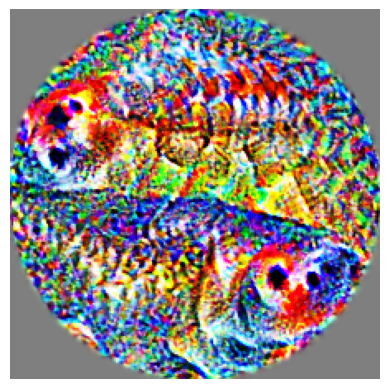

In [8]:
np_patch = np.load('./np_patch.npy')*255
#tf_patch = bgr_to_rgb(tf_patch)
np_patch = np_patch.transpose(1, 2, 0)
#pt_patch = np.flip(pt_patch,axis=1).copy()
np_patch = np_patch[...,::-1].copy()

plt.axis("off")
plt.imshow((bgr_to_rgb(np_patch)).astype(np.uint))
plt.show()

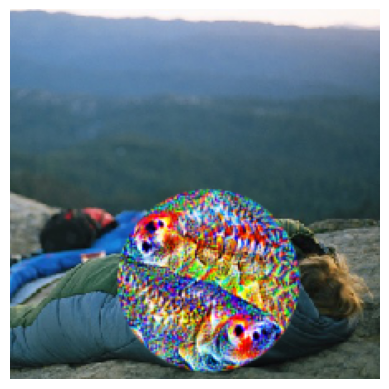

Predictions:
sleeping_bag  0.48
parachute     0.15
Airedale      0.05
mountain_tent 0.03
brain_coral   0.02


In [9]:
ap = AdversarialPatchTensorFlowV2(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

plt.axis("off")
patched_images = ap.apply_patch(images, scale=0.5, patch_external=np_patch)
predict_model(tfc, patched_images[0])

## Pytorch estimator, TensorFlow patch

In [10]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.models import resnet

from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model

from art.estimators.classification.pytorch import PyTorchClassifier
from art.attacks.evasion import AdversarialPatchPyTorch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose, transforms

import cv2
import matplotlib
import matplotlib.pyplot as plt

import PIL.Image
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

import os
import glob
import gzip
import pickle

plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"

'''
Predict top 5 classes for image
'''
def predict_model(classifier, image):
    plt.axis("off")
    plt.imshow(image.transpose(1,2,0))
    plt.show()

    predictions = classifier.predict(np.array([image]))
    predictions = torch.nn.functional.softmax(torch.Tensor(predictions), dim=1).numpy()

    top_5 = np.argsort(-predictions)[:, :5]

    for idx in top_5[0].tolist():
        print(label_to_name(idx)+':', predictions[0][idx])

#### Hyperparamters

In [11]:
target_name = 'goldfish, Carassius auratus'
image_shape = (3, 224, 224)
clip_values = (0, 1)
nb_classes  = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

#### Model definition

In [12]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

ptc = PyTorchClassifier(model=model, loss=torch.nn.CrossEntropyLoss, nb_classes=nb_classes, 
                                        input_shape=image_shape, clip_values=clip_values, device_type="cuda",
                                        preprocessing=(MEAN, STD))

#### ImageNet images

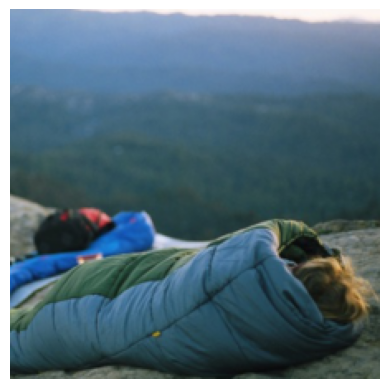

sleeping bag: 0.3727104
mountain tent: 0.02019634
binoculars, field glasses, opera glasses: 0.012218014
valley, vale: 0.008150697
volcano: 0.007430867


In [13]:
images_list = list()
preprocess = transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

for image_path in imagenet_stubs.get_image_paths():
    im = PIL.Image.open(image_path)
    im = preprocess(im).numpy()
    images_list.append(im)

images = np.array(images_list)

predict_model(ptc, images[0])

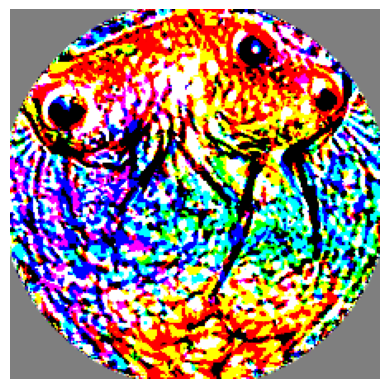

In [14]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]
tf_patch = (np.load('./tf_patch.npy') / 255)
#tf_patch = bgr_to_rgb(tf_patch)
tf_patch = tf_patch.transpose(2, 0, 1)
# https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663/9
tf_patch = torch.from_numpy(np.flip(tf_patch,axis=0).copy()).numpy()

plt.axis("off")
plt.imshow(((tf_patch)).transpose(1,2,0))
plt.show()

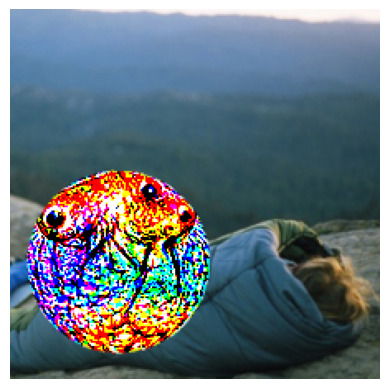

terrapin: 0.061194595
mud turtle: 0.056760933
Gila monster, Heloderma suspectum: 0.035197582
dung beetle: 0.017923588
eel: 0.017634416


In [15]:
ap = AdversarialPatchPyTorch(estimator=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(3, 224, 224), verbose=True)

patched_images = ap.apply_patch(images, scale=0.5, patch_external=tf_patch)
predict_model(ptc, patched_images[0])

## Pytorch Estimator, Numpy patch

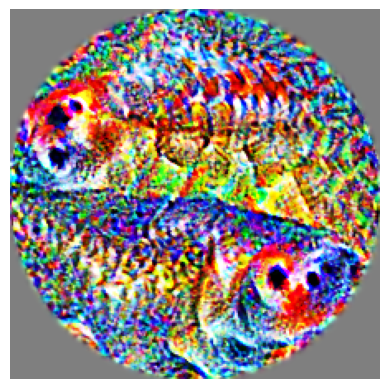

In [18]:
np_patch = np.load('./np_patch.npy')

plt.axis("off")
plt.imshow(((np_patch)).transpose(1,2,0))
plt.show()

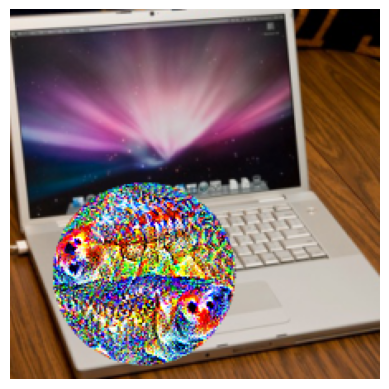

goldfish, Carassius auratus: 0.57507247
notebook, notebook computer: 0.1335465
laptop, laptop computer: 0.02925383
computer keyboard, keypad: 0.014160305
mouse, computer mouse: 0.011837376


In [20]:
'''ap = AdversarialPatchNumpy(classifier=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)'''
ap = AdversarialPatchPyTorch(estimator=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(3, 224, 224), verbose=True)

patched_images = ap.apply_patch(images, scale=0.5, patch_external=np_patch)
predict_model(ptc, patched_images[-1])